In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from gpmap.utils import hamming_distance

from latticeproteins.conformations import Conformations
from latticeproteins.evolution import Evolution, AdaptiveWalk
from latticeproteins.fitness import Fitness
from latticeproteins.sequences import RandomSequence

from latticegpm.gpm import LatticeGenotypePhenotypeMap

from epistasis.models.nonlinear.regression import EpistasisNonlinearRegression
from epistasis.models.linear.regression import EpistasisLinearRegression
from epistasis.models.nonlinear.power import EpistasisPowerTransform

In [2]:
from functools import wraps

class ConstrainedFitness(Fitness):
    """Wraps latticeproteins ``Fitness`` model to select for a single conformation
    """
    @wraps(Fitness.__init__)
    def __init__(self, temperature, conf_database, fitconf, *args, **kwargs):
        """Hacked fitness
        
        New argument
        ------------
        fitconf : str
            conformation to fit. all other conformations are lethal
        """
        self.fitconf = fitconf
        super(ConstrainedFitness, self).__init__(temperature, conf_database, *args, **kwargs)
        
    def Fitness(self, seq):
        """Computes the fitness from a given stability value"""
        nativeE_results = self._NativeE(seq)
        conf = nativeE_results[1]
        if conf != fitconf:
            return 0
        else:
            stability_results = self._Stability(*nativeE_results)
            fitness_results = self._Fitness(*stability_results)
            return fitness_results[0]        

In [3]:
length = 10
temperature = 1.0
dGdependence= "fracfolded"
conf_database = Conformations(length)

In [4]:
wildtype = "".join(RandomSequence(length))
popsize = 20
mutrate = 0.001
numsteps = 5
f = None
output = conf_database.FoldSequence(wildtype, temperature)
fitconf = output[1]
#fitness = ConstrainedFitness(temperature, conf_database, fitconf=fitconf, dGdependence=dGdependence)
fitness = Fitness(temperature, conf_database, dGdependence=dGdependence)
finalpop = AdaptiveWalk(wildtype, fitness, numsteps, file=f, steepest_ascent=True)
mutant = finalpop[0]
order = hamming_distance(wildtype, mutant)
print(order)
print('"'+wildtype+'", "'+mutant+'"')

5
"GEKCMVDPFL", "GFKKCVDKFT"


In [5]:
fitness.Fitness(mutant)

0.8432953604362323

In [6]:
1 - fitness.Fitness(wildtype)

0.8798451357681454

In [7]:
def evolve():
    wildtype = "".join(RandomSequence(length))
    popsize = 50
    mutrate = 0.6
    numsteps = 100
    f = None
    output = conf_database.FoldSequence(wildtype, temperature)
    fitconf = output[1]
    fitness = ConstrainedFitness(temperature, conf_database, fitconf=fitconf, dGdependence=dGdependence)
    finalpop = Evolution(wildtype, fitness, popsize, mutrate, numsteps, file=f)
    mutant = finalpop[0]
    return wildtype, mutant


In [6]:
with open("sequences.txt", "w") as f:
    counter = 0
    while counter < 100:
        wt, mut = evolve()
        hd = hamming_distance(wt, mut)
        if hd == 15:
            f.write(wt + ", " + mut + "\n")
            counter += 1
f.close()

In [13]:
wt = "GVCKCLCFVTEGVED"
mu = "REWSIMMMGWGYYVN"
temperature = 1
gpm = LatticeGenotypePhenotypeMap.from_mutant(wt, mu, conf_database, temperature=temperature)

In [ ]:
model = EpistasisLinearRegression.from_gpm(gpm, order=order, model_type="global")
model.fit()

In [ ]:
model = EpistasisPowerTransform.from_gpm(gpm, order=1, model_type="global", fix_linear=True)
model.fit()

In [ ]:
np.unique(model.gpm.conformations)

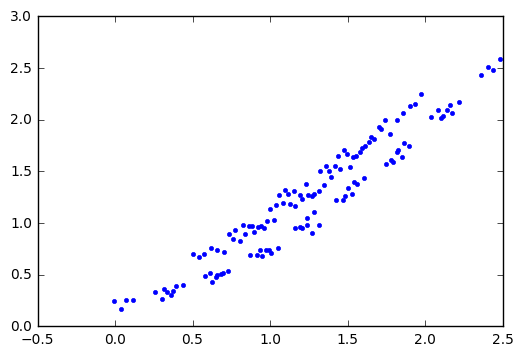

In [33]:
plt.plot(model.predict_linear(), model.gpm.phenotypes, '.')

<Container object of 2036 artists>

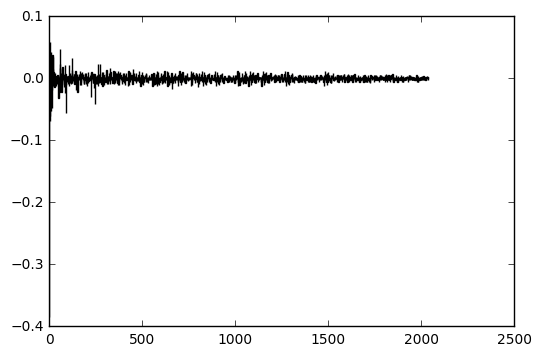

In [30]:
y = model.epistasis.values[order+1:]
x = range(len(y))
plt.bar(x, y, width=1)

In [2]:
import math

In [5]:
math.factorial(12)

479001600

In [1]:
from latticegpm.gpm import LatticeGenotypePhenotypeMap
from latticeproteins.conformations import Conformations

In [2]:
c = Conformations(8, "database")
s = LatticeGenotypePhenotypeMap.from_length(8, c)

In [3]:
s.to_json("test.json")

In [4]:
t = LatticeGenotypePhenotypeMap.from_json("test.json")

In [13]:
t.